# Baseline Synchrony Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm

In [2]:
TABLES_DIRECTORY = "../../Data/all_giant_tables"

In [3]:
def get_patient_hup_ids(directory):
    # List all files in the directory
    files = os.listdir(directory)

    # Filter out files based on the given pattern and extract patient_hup_id as integers
    patient_hup_ids = [
        int(f.split("_")[1].split(".")[0]) for f in files if f.startswith("HUP_")
    ]

    return patient_hup_ids


directory = "../../Data/giant_new_tables"
completed_hup_ids = get_patient_hup_ids(TABLES_DIRECTORY)
completed_hup_ids.sort()
print(completed_hup_ids)
len(completed_hup_ids)

[137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 202, 204, 205, 206, 207, 210, 217, 219, 221, 223, 225]


71

In [4]:
reinitiation_hup_ids = [142, 145, 166, 173, 174, 177, 180]
reinitiation_start_time_minutes = [17700, 16500, 9950, 12500, 8200, 12050, 9450]
assert len(reinitiation_hup_ids) == len(reinitiation_start_time_minutes)

## Individual Patients

In [ ]:
def combined_plot(hourly_patient_features_df, hup_id):
    fig = plt.figure(figsize=(15, 6))
    gs = gridspec.GridSpec(3, 2, width_ratios=[2, 1])

    # Plotting Individual ASMs
    ax0 = plt.subplot(gs[0, 0])

    med_cols = [
        col
        for col in hourly_patient_features_df.columns
        if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
    ]
    med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

    for i, col in enumerate(med_cols):
        if col != "med_sum_no_lorazepam_raw":
            label = med_cols_no_raw[i].replace("med_", "")
            normalized_data = (
                hourly_patient_features_df[col] / hourly_patient_features_df[col].max()
            )
            ax0.plot(hourly_patient_features_df["emu_minute"], normalized_data)

    seizure_minutes = hourly_patient_features_df[
        hourly_patient_features_df["had_seizure"] >= 1
    ]["emu_minute"].values
    for idx in seizure_minutes:
        ax0.axvline(x=idx, color="red", linestyle="dotted")

    ax0.set_ylabel("Load")
    ax0.set_ylim([0, 1.3])
    ax0.set_title("Individual ASMs")

    # Plotting Total ASM
    ax1 = plt.subplot(gs[1, 0], sharex=ax0)
    ax1.plot(
        hourly_patient_features_df["emu_minute"],
        hourly_patient_features_df["med_sum_no_lorazepam_raw"],
    )
    ax1.set_ylabel("Load")
    ax1.set_title("Total ASM")

    # Plotting synchrony (broadband Band)
    ax2 = plt.subplot(gs[2, 0], sharex=ax0)
    ax2.plot(
        hourly_patient_features_df["emu_minute"],
        hourly_patient_features_df["synchrony_broadband"],
    )
    ax2.set_ylabel("Synchrony")
    ax2.set_title("Synchrony")
    ax2.set_xlabel("Time (minutes)")

    # Scatter plot with regression results
    ax3 = plt.subplot(gs[:, 1])

    seizure_indices = hourly_patient_features_df[
        hourly_patient_features_df["had_seizure"] >= 1
    ].index

    valid_seizure_indices = [
        idx
        for i, idx in enumerate(seizure_indices)
        if i == 0 or (seizure_indices[i] - seizure_indices[i - 1]) >= 120
    ]

    avg_synchronies = []
    avg_med_loads = []

    for idx in valid_seizure_indices:
        seizure_time = hourly_patient_features_df.loc[idx, "emu_minute"]

        window = hourly_patient_features_df[
            (hourly_patient_features_df["emu_minute"] >= seizure_time - 120)
            & (hourly_patient_features_df["emu_minute"] < seizure_time)
        ]
        if len(window["synchrony_broadband"]) == 0 or np.all(
            np.isnan(window["synchrony_broadband"])
        ):
            print("Bad, no data")
            completed_hup_ids.remove(
                patient_hup_id
            )  # Remove the patient_hup_id from completed_hup_ids
            break  # Skip the rest of the current iteration

        avg_synchrony = np.nanmean(window["synchrony_broadband"])
        avg_med_load = np.nanmean(window["med_sum_no_lorazepam_raw"])

        avg_synchronies.append(avg_synchrony)
        avg_med_loads.append(avg_med_load)

    if avg_med_loads and avg_synchronies:
        sns.regplot(
            x=avg_med_loads,
            y=avg_synchronies,
            scatter=True,
            line_kws={"color": "red"},
            ci=None,
            ax=ax3,
        )

        # Label each dot with its respective seizure number
        for i, (x, y) in enumerate(zip(avg_med_loads, avg_synchronies)):
            ax3.text(x, y, f"Seizure {i+1}", fontsize=8, ha="right")

        ax3.set_xlabel("Average ASM Load")
        ax3.set_ylabel("Average Baseline Synchrony")
        ax3.set_title(f"Baseline Synchrony vs ASM")
        ax3.grid(True)

    # Subtitle
    fig.suptitle(f"HUP {hup_id}", fontsize=16)
    plt.tight_layout()
    plt.show()


# Loop to call combined_plot
for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    combined_plot(hourly_patient_features_df, patient_hup_id)

In [ ]:
# Loop to call combined_plot
for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    combined_plot(hourly_patient_features_df, patient_hup_id)

## Across All Patients

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.296
Date:                Wed, 07 Feb 2024   Prob (F-statistic):              0.132
Time:                        06:58:47   Log-Likelihood:                 360.53
No. Observations:                 172   AIC:                            -717.1
Df Residuals:                     170   BIC:                            -710.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1252      0.003     36.569      0.0

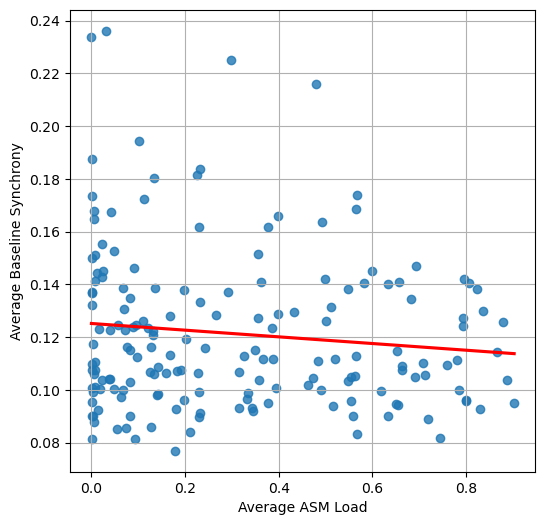

In [11]:
def get_seizure_data(hourly_patient_features_df):
    """
    For a given hourly_patient_features_df, return a list of tuples.
    Each tuple contains avg_med_load and avg_synchrony for each seizure.
    """
    seizure_indices = hourly_patient_features_df[
        hourly_patient_features_df["had_seizure"] >= 1
    ].index

    valid_seizure_indices = [
        idx
        for i, idx in enumerate(seizure_indices)
        if i == 0 or (seizure_indices[i] - seizure_indices[i - 1]) >= 5 * 60
    ]

    seizure_data = []

    for idx in valid_seizure_indices:
        seizure_time = hourly_patient_features_df.loc[idx, "emu_minute"]

        window = hourly_patient_features_df[
            (hourly_patient_features_df["emu_minute"] >= seizure_time - 60)
            & (hourly_patient_features_df["emu_minute"] < seizure_time)
        ]
        if len(window["synchrony_broadband"]) == 0 or np.all(
            np.isnan(window["synchrony_broadband"])
        ):
            continue  # Skip the rest of the current iteration

        avg_synchrony = np.nanmean(window["synchrony_broadband"])
        avg_med_load = np.nanmean(window["med_sum_no_lorazepam_raw"])

        if avg_synchrony < 0.6:
            seizure_data.append((avg_med_load, avg_synchrony))

    return seizure_data


# Accumulate data from all patients
all_seizures_data = []

for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    all_seizures_data.extend(get_seizure_data(hourly_patient_features_df))

# Scatter plot
plt.figure(figsize=(6, 6))
avg_med_loads, avg_synchronies = zip(*all_seizures_data)

# Convert tuples to lists
avg_med_loads_list = list(avg_med_loads)
avg_synchronies_list = list(avg_synchronies)

# Fit an OLS regression model
X = sm.add_constant(avg_med_loads_list)  # Adding a constant for the intercept
model = sm.OLS(avg_synchronies_list, X).fit()

# Print out the statistics
print(model.summary())

sns.regplot(
    x=avg_med_loads_list,
    y=avg_synchronies_list,
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
)

plt.xlabel("Average ASM Load")
plt.ylabel("Average Baseline Synchrony")
plt.grid(True)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7118
Date:                Wed, 07 Feb 2024   Prob (F-statistic):              0.402
Time:                        06:59:51   Log-Likelihood:                 125.03
No. Observations:                  63   AIC:                            -246.1
Df Residuals:                      61   BIC:                            -241.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1268      0.007     19.263      0.0

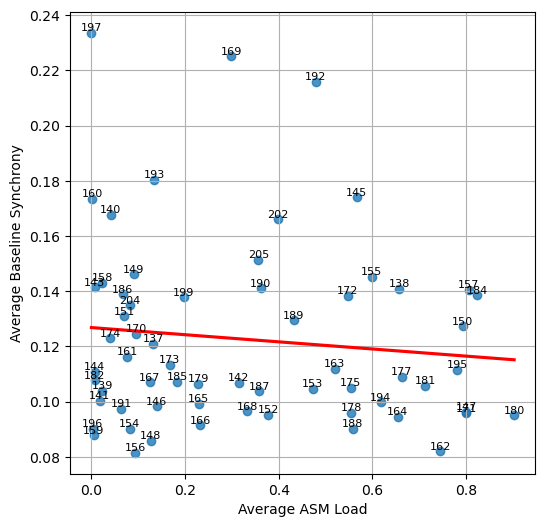

In [13]:
all_seizures_data = []

# Iterate through all patient data
for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Get only the first seizure index
    first_seizure_idx = (
        hourly_patient_features_df[
            hourly_patient_features_df["had_seizure"] >= 1
        ].index[0]
        if not hourly_patient_features_df[
            hourly_patient_features_df["had_seizure"] >= 1
        ].empty
        else None
    )

    if first_seizure_idx:
        seizure_time = hourly_patient_features_df.loc[first_seizure_idx, "emu_minute"]

        window = hourly_patient_features_df[
            (hourly_patient_features_df["emu_minute"] >= seizure_time - 60)
            & (hourly_patient_features_df["emu_minute"] < seizure_time)
        ]

        if len(window["synchrony_broadband"]) == 0 or np.all(
            np.isnan(window["synchrony_broadband"])
        ):
            continue  # Skip the rest of the current iteration

        avg_synchrony = np.nanmean(window["synchrony_broadband"])
        avg_med_load = np.nanmean(window["med_sum_no_lorazepam_raw"])

        if avg_synchrony < 0.6:
            all_seizures_data.append((avg_med_load, avg_synchrony))

# Scatter plot
plt.figure(figsize=(6, 6))
avg_med_loads, avg_synchronies = zip(*all_seizures_data)
avg_med_loads_list = list(avg_med_loads)
avg_synchronies_list = list(avg_synchronies)

# Fit an OLS regression model
X = sm.add_constant(avg_med_loads_list)  # Adding a constant for the intercept
model = sm.OLS(avg_synchronies_list, X).fit()

# Print out the statistics
print(model.summary())

sns.regplot(
    x=avg_med_loads_list,
    y=avg_synchronies_list,
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
)

for i, (x, y) in enumerate(zip(avg_med_loads_list, avg_synchronies_list)):
    plt.text(x, y, f"{completed_hup_ids[i]}", fontsize=8, ha="center", va="bottom")

plt.xlabel("Average ASM Load")
plt.ylabel("Average Baseline Synchrony")
plt.grid(True)
plt.show()